In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
token_path = "/content/gdrive/MyDrive/ImageCaptioningProject/dataset/Flickr8k.token.txt"
train_images_path = '/content/gdrive/MyDrive/ImageCaptioningProject/dataset/Flickr_8k.trainImages.txt'
test_images_path = '/content/gdrive/MyDrive/ImageCaptioningProject/dataset/Flickr_8k.testImages.txt'
images_path = '/content/gdrive/MyDrive/ImageCaptioningProject/dataset/Flicker8k_Dataset/'
glove_path = '/content/gdrive/MyDrive/ImageCaptioningProject/Glob/glove.6B.200d.txt'

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [ ]:
doc = open(token_path,'r').read()
# print(doc[:410])

In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)
table

{33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None}

In [ ]:
# vocabulary = set()
# for key in descriptions.keys():
#         [vocabulary.update(d.split()) for d in descriptions[key]]
        
# print('Original Vocabulary Size: %d' % len(vocabulary))

In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)


In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
  # print("i- ",i,i[len(images_path):])
  if i[len(images_path):] in train_images:
    train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
  if i[len(images_path):] in test_images: 
    test_img.append(i)

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
word_count_threshold = 9
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1770


In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
embeddings_index = {} 
f = open(glove_path, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 12s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:


def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # print("shape",x.shape)
    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:

encoding_train = {}
count =0
for img in train_img:
  encoding_train[img[len(images_path):]] = encode(img)
  print(count)
  count +=1
train_features = encoding_train

encoding_test = {}
count1=0
for img in test_img:
  encoding_test[img[len(images_path):]] = encode(img)
  print(count1)
  count1 +=1

Streaming output truncated to the last 5000 lines.
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189

In [ ]:
encoding_test

{'106490881_5a2dd9b7bd.jpg': array([0.4193278 , 0.19502947, 0.11467601, ..., 0.3960283 , 1.3721384 ,
        0.24658547], dtype=float32),
 '2484190118_e89363c465.jpg': array([0.83333033, 0.41687515, 1.0055859 , ..., 0.2744123 , 0.8372064 ,
        0.0054179 ], dtype=float32),
 '2265096094_8cc34d669c.jpg': array([0.4536202 , 0.5865969 , 0.48372954, ..., 0.05096572, 0.24688534,
        0.6804421 ], dtype=float32),
 '3591462960_86045906bd.jpg': array([0.34657198, 0.10415627, 0.6855624 , ..., 0.64734316, 0.3946163 ,
        0.00815428], dtype=float32),
 '3191135894_2b4bdabb6d.jpg': array([0.97761554, 0.519371  , 0.60743356, ..., 0.32890475, 0.18746988,
        0.64046025], dtype=float32),
 '3567061016_62768dcce1.jpg': array([0.432012  , 0.21093331, 0.18525264, ..., 0.21668336, 0.0887423 ,
        0.02262333], dtype=float32),
 '3514019869_7de4ece2a5.jpg': array([0.24316509, 0.45671475, 0.7045684 , ..., 0.17671427, 0.22483005,
        0.22111943], dtype=float32),
 '2542662402_d781dd7f7c.jpg'

In [ ]:

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      354200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[0:3]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam' ,metrics=['acc'])

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)

In [ ]:
from tensorflow import keras

In [ ]:
callbacks =[keras.callbacks.ModelCheckpoint(filepath ='ImageCaption.h5', monitor='loss', verbose=1, save_best_only=True)]

model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1,callbacks=callbacks)


Epoch 1/30
2000/2000 [==============================] - 279s 137ms/step - loss: 4.1770 - acc: 0.2642

Epoch 00001: loss improved from inf to 3.71433, saving model to ImageCaption.h5
Epoch 2/30
2000/2000 [==============================] - 273s 136ms/step - loss: 3.1101 - acc: 0.3556

Epoch 00002: loss improved from 3.71433 to 3.05416, saving model to ImageCaption.h5
Epoch 3/30
2000/2000 [==============================] - 275s 137ms/step - loss: 2.8709 - acc: 0.3767

Epoch 00003: loss improved from 3.05416 to 2.84700, saving model to ImageCaption.h5
Epoch 4/30
2000/2000 [==============================] - 278s 139ms/step - loss: 2.7393 - acc: 0.3895

Epoch 00004: loss improved from 2.84700 to 2.72584, saving model to ImageCaption.h5
Epoch 5/30
2000/2000 [==============================] - 278s 139ms/step - loss: 2.6453 - acc: 0.3976

Epoch 00005: loss improved from 2.72584 to 2.63909, saving model to ImageCaption.h5
Epoch 6/30
2000/2000 [==============================] - 281s 140ms/step - 

In [ ]:
epochs=10
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1,callbacks=callbacks)

Epoch 1/10
2000/2000 [==============================] - 281s 141ms/step - loss: 2.1658 - acc: 0.4513

Epoch 00001: loss improved from 2.16730 to 2.16576, saving model to ImageCaption.h5
Epoch 2/10
2000/2000 [==============================] - 281s 141ms/step - loss: 2.1557 - acc: 0.4530

Epoch 00002: loss improved from 2.16576 to 2.15570, saving model to ImageCaption.h5
Epoch 3/10
2000/2000 [==============================] - 282s 141ms/step - loss: 2.1571 - acc: 0.4521

Epoch 00003: loss did not improve from 2.15570
Epoch 4/10
2000/2000 [==============================] - 283s 141ms/step - loss: 2.1498 - acc: 0.4531

Epoch 00004: loss improved from 2.15570 to 2.14981, saving model to ImageCaption.h5
Epoch 5/10
2000/2000 [==============================] - 281s 141ms/step - loss: 2.1438 - acc: 0.4545

Epoch 00005: loss improved from 2.14981 to 2.14383, saving model to ImageCaption.h5
Epoch 6/10
2000/2000 [==============================] - 281s 141ms/step - loss: 2.1417 - acc: 0.4548

Epoch

In [ ]:

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:

from keras.models import load_model
import pickle
model = load_model('/content/gdrive/MyDrive/ImageCaptioningProject/ImageCaption.h5')


In [ ]:

import matplotlib.pyplot as plt

In [ ]:
dbfile = open('/content/gdrive/MyDrive/ImageCaptioningProject/encoding_test.pickle', 'rb')     
encoding_test = pickle.load(dbfile)

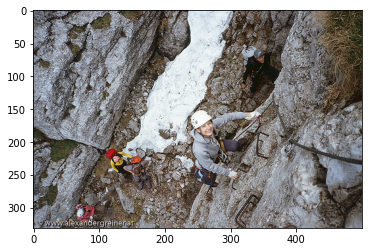

Greedy Search: a man climbing a rock face


In [ ]:
pic = '3502343542_f9b46688e5.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

In [ ]:
import cv2
import numpy as np


In [ ]:
cap = cv2.VideoCapture('/content/gdrive/MyDrive/ImageCaptioningProject/video.mp4')
import time
i=0
while (cap.isOpened()):
    ret,img = cap.read()
    if ret==True:
      if i % 50 ==0:
        
        print(img.shape)
        plt.imshow(img)
        plt.show()
        img = cv2.resize(img, (299, 299))
        print(img.shape)
        x = np.expand_dims(img, axis=0)
        print("shape",x.shape)
        x = preprocess_input(x)

        fea_vec = model_new.predict(x) 
        fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
        fea_vec = fea_vec.reshape((1,2048))


        print("greedy--",greedySearch(fea_vec))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        # time.sleep(3)

    
      i+=1
      if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cp /content/video.mp4 /content/gdrive/MyDrive/ImageCaptioningProject/

In [ ]:
!pip install pytube

     |████████████████████████████████| 51kB 2.7MB/s 


In [ ]:
import nltk

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [1]:
!wget https://github.com/ferasbg/glioAI/blob/master/glioai/models/tumor_prediction.h5

--2021-05-01 11:49:48--  https://github.com/ferasbg/glioAI/blob/master/glioai/models/tumor_prediction.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘tumor_prediction.h5’

tumor_prediction.h5     [ <=>                ] 106.23K  --.-KB/s    in 0.007s  

2021-05-01 11:49:48 (14.0 MB/s) - ‘tumor_prediction.h5’ saved [108775]

